### Advanced Machine Learning

# Home Exercise #4

Assignment Due: 17/05/21 23:59

Jonathan Schler

In [1]:
student1Name="Matan Mizrachi" # student1 name here
student1ID="207299363" # student1 ID here


student2Name="Ron Yosef" # student2 name here
student2ID="318466711" # student2 ID here

The goal of this homework is to try to solve the problem of predicting wine quality from review texts and other properties of the wine. You can find the dataset here:https://www.kaggle.com/zynicide/wine-reviews

While you can find several kernels on kaggle already, I highly recommend you start your ownsolution from scratch. For this homework, only use wine from the United States (only 42% of data). Feel free to subsample the data for building your model.

## Task 1 Bag of Words and simple Features [50pts]

1.1 Create a baseline model for predicting wine quality using only non-text features.





In [1]:
import pandas as pd
import numpy as np
x = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)
x.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [2]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


As per the requirements, we drop the text-based column. Moreover, since we are working on a baseline model, we shall drop the _region_2_ column, for it has high percentage of missing values, then, we'll drop the rows that contains of missing values.

In [3]:
x.drop(columns=['description', 'region_2'], inplace=True)
x.dropna(inplace=True)
y = x['points']
x.drop(columns=['points'], inplace=True)

In [4]:
np.unique(y, return_counts=True)

(array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100], dtype=int64),
 array([ 133,  179,  470,  904, 1746, 2786, 3999, 5799, 6958, 5398, 6713,
        5668, 4816, 3450, 1985,  738,  231,   80,   34,   12,    7],
       dtype=int64))

The data isn't balanced, so we'll use SMOTE to balance it, before we move forward.

In [5]:
cat = x.dtypes == object
x.loc[:, cat] = x.loc[:, cat].apply(lambda z: z.astype('category').cat.codes)

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.preprocessing import StandardScaler

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [8]:
from imblearn.over_sampling import SMOTE
x_train, y_train = SMOTE().fit_resample(x_train, y_train)

In [11]:
%%capture
base_model = make_pipeline(StandardScaler(), LR()).fit(x_train, y_train)

In [12]:
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve, plot_confusion_matrix
print(classification_report(y_test, base_model.predict(x_test)))
print(f"AUC = {roc_auc_score(y_test, base_model.predict_proba(x_test), multi_class='ovr')}")

              precision    recall  f1-score   support

          80       0.02      0.40      0.03        30
          81       0.02      0.16      0.03        37
          82       0.02      0.14      0.04        94
          83       0.05      0.03      0.04       173
          84       0.07      0.10      0.08       367
          85       0.07      0.09      0.08       572
          86       0.14      0.14      0.14       817
          87       0.19      0.09      0.12      1152
          88       0.16      0.09      0.12      1372
          89       0.18      0.22      0.20      1077
          90       0.19      0.12      0.15      1287
          91       0.20      0.10      0.13      1143
          92       0.19      0.08      0.11       967
          93       0.15      0.15      0.15       700
          94       0.14      0.16      0.15       404
          95       0.06      0.11      0.08       144
          96       0.06      0.13      0.09        55
          97       0.00    

The results are not good at all. We expect to get a model to could do way better than that.

1.2 Create a simple text-based model using a bag-of-words approach and a linear model.


In [1]:
import pandas as pd
import numpy as np
x = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)
to_remove = x.columns.to_list()
to_remove.remove('points')
to_remove.remove('description')
x.drop(columns=to_remove, inplace=True)
y = x['points']
x.drop(columns=['points'], inplace=True)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words='english')
x_train = vect.fit_transform(x_train['description'].to_list())
x_test = vect.transform(x_test['description'].to_list())

In [4]:
from imblearn.over_sampling import SMOTE
x_train, y_train = SMOTE().fit_resample(x_train, y_train)

In [5]:
%%capture
lr = LR().fit(x_train, y_train)

In [6]:
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, lr.predict(x_test)))
print(f"AUC = {roc_auc_score(y_test, lr.predict_proba(x_test), multi_class='ovr')}")

              precision    recall  f1-score   support

          80       0.25      0.16      0.20        82
          81       0.15      0.11      0.13       145
          82       0.22      0.22      0.22       347
          83       0.21      0.17      0.18       656
          84       0.26      0.28      0.27      1284
          85       0.24      0.23      0.23      1881
          86       0.24      0.23      0.23      2475
          87       0.28      0.29      0.29      3399
          88       0.25      0.24      0.24      3430
          89       0.22      0.19      0.20      2500
          90       0.26      0.25      0.25      3114
          91       0.21      0.20      0.21      2289
          92       0.21      0.23      0.22      1854
          93       0.19      0.19      0.19      1328
          94       0.17      0.18      0.17       749
          95       0.10      0.15      0.12       280
          96       0.01      0.02      0.02       100
          97       0.05    

1.3 Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoW model. Be aware that you might need to adjust the (regularization of the) linear model for different feature sets.


### TF-IDF

In [1]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression as LR
from imblearn.over_sampling import SMOTE
x = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)
to_remove = x.columns.to_list()
to_remove.remove('points')
to_remove.remove('description')
x.drop(columns=to_remove, inplace=True)
y = x['points']
x.drop(columns=['points'], inplace=True)

In [2]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [6]:
transformer = make_pipeline(CountVectorizer(stop_words='english'), TfidfTransformer()).fit(x_train['description'].to_list())

In [7]:
x_train = transformer.transform(x_train['description'].to_list())
x_test = transformer.transform(x_test['description'].to_list())

In [8]:
x_train, y_train = SMOTE().fit_resample(x_train, y_train)

In [9]:
%%capture
lr = LR().fit(x_train, y_train)

In [10]:
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, lr.predict(x_test)))
print(f"AUC = {roc_auc_score(y_test, lr.predict_proba(x_test), multi_class='ovr')}")

C:\Users\Matan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Matan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Matan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          80       0.13      0.26      0.17        78
          81       0.08      0.25      0.12       124
          82       0.15      0.26      0.19       389
          83       0.13      0.26      0.17       602
          84       0.19      0.22      0.20      1284
          85       0.22      0.24      0.23      1885
          86       0.24      0.19      0.21      2474
          87       0.28      0.22      0.25      3335
          88       0.27      0.20      0.23      3473
          89       0.23      0.22      0.22      2449
          90       0.27      0.20      0.23      3133
          91       0.22      0.21      0.22      2295
          92       0.24      0.22      0.23      2000
          93       0.18      0.22      0.20      1272
          94       0.15      0.29      0.20       735
          95       0.10      0.27      0.14       293
          96       0.02      0.06      0.03       109
          97       0.08    

In [11]:
from sklearn.preprocessing import normalize

In [13]:
%%capture
lr = LR().fit(normalize(x_train, norm='l2'), y_train)

In [14]:
print(classification_report(y_test, lr.predict(x_test)))
print(f"AUC = {roc_auc_score(y_test, lr.predict_proba(x_test), multi_class='ovr')}")

              precision    recall  f1-score   support

          80       0.13      0.24      0.17        78
          81       0.08      0.21      0.11       124
          82       0.15      0.28      0.20       389
          83       0.13      0.21      0.16       602
          84       0.19      0.24      0.21      1284
          85       0.22      0.21      0.22      1885
          86       0.23      0.21      0.22      2474
          87       0.27      0.23      0.25      3335
          88       0.25      0.20      0.22      3473
          89       0.23      0.23      0.23      2449
          90       0.27      0.20      0.23      3133
          91       0.22      0.24      0.23      2295
          92       0.24      0.22      0.23      2000
          93       0.20      0.23      0.21      1272
          94       0.16      0.26      0.20       735
          95       0.10      0.22      0.14       293
          96       0.05      0.06      0.05       109
          97       0.06    

C:\Users\Matan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Matan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Matan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### N-Grams

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [7]:
from sklearn.metrics import f1_score, average_precision_score, recall_score, classification_report, roc_auc_score
results = np.zeros((4, 4))
count = 0
for i in [(1, 1), (1, 2), (2, 2), (2, 3)]:
    transformer = CountVectorizer(stop_words='english', ngram_range=i).fit(x_train['description'].to_list())
    x_train = transformer.transform(x_train['description'].to_list())
    x_test = transformer.transform(x_test['description'].to_list())
    x_train, y_train = SMOTE().fit_resample(x_train, y_train)
    lr = LR().fit(x_train, y_train)
    results[count, 0] = lr.score(x_test, y_test)
    results[count, 1] = roc_auc_score(y_test, lr.predict_proba(x_test), multi_class='ovr')
    results[count, 2] = f1_score(y_test, lr.predict(x_test), average='macro')
    results[count, 3] = recall_score(y_test, lr.predict(x_test), average='macro')
    count += 1
    print('count = ', count)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


C:\Users\Matan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


count =  1


C:\Users\Matan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


count =  2


C:\Users\Matan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


count =  3


C:\Users\Matan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


count =  4


In [9]:
pd.DataFrame(data=results, index=[(1, 1), (1, 2), (2, 2), (2, 3)], columns=['accuracy', 'auc', 'f1', 'recall'])

,accuracy,auc,f1,recall
"(1, 1)",0.236622,0.782689,0.174187,0.174153
"(1, 2)",0.303943,0.792835,0.208129,0.208173
"(2, 2)",0.283285,0.749124,0.186470,0.194465
"(2, 3)",0.276976,0.757223,0.173667,0.198477


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
transformer = CountVectorizer(stop_words='english', ngram_range=(2, 5), analyzer='char_wb').fit(x_train['description'].to_list())
x_train = transformer.transform(x_train['description'].to_list())
x_test = transformer.transform(x_test['description'].to_list())
x_train, y_train = SMOTE().fit_resample(x_train, y_train)
lr = LR().fit(x_train, y_train)

C:\Users\Matan\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:502: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"
C:\Users\Matan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
print(classification_report(y_test, lr.predict(x_test)))
print(f"AUC = {roc_auc_score(y_test, lr.predict_proba(x_test), multi_class='ovr')}")

              precision    recall  f1-score   support

          80       0.39      0.08      0.14        83
          81       0.17      0.10      0.12       144
          82       0.19      0.25      0.21       370
          83       0.16      0.13      0.14       598
          84       0.27      0.24      0.25      1352
          85       0.22      0.20      0.21      1928
          86       0.24      0.23      0.23      2497
          87       0.26      0.30      0.28      3401
          88       0.23      0.24      0.24      3479
          89       0.20      0.15      0.17      2442
          90       0.23      0.31      0.27      3023
          91       0.22      0.19      0.20      2244
          92       0.22      0.20      0.21      1907
          93       0.20      0.20      0.20      1280
          94       0.16      0.15      0.15       755
          95       0.10      0.13      0.11       307
          96       0.04      0.04      0.04       112
          97       0.08    

#### Mid Q summary:
Up to this point, we went easy on ourselves by not cross-validating anything, nor giving much care about the pre-processing.
However, we'll take care of it all in the next part.

1.4 Combine the non-text features and the text features. How does adding those features improve upon just using bag-of-words?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
x = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)
x = x.loc[x['country'] == 'US']
y = x['points']
x.drop(columns=['points', 'country'], inplace=True)
x.head(3)

,description,designation,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
2,"Tart and snappy, the flavors of lime flesh and...",NaN,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [2]:
x.loc[x['region_1'].isna()] = x.loc[x['region_1'].isna()].assign(region_1 = 'Nan')
x.loc[x['region_2'].isna()] = x.loc[x['region_2'].isna()].assign(region_2 = 'Nan')

In [3]:
names = x['taster_name'].unique()
for n in names:
    sub_df = x.loc[x['taster_name'] == n]['taster_twitter_handle']
    if sub_df.isna().sum() == len(sub_df):
        x.loc[(x['taster_name'] == n) & x['taster_twitter_handle'].isna(), 'taster_twitter_handle'] = 'Nan'
        continue
    elif sub_df.isna().sum() == 0:
        continue
    new_t = sub_df[~sub_df.isna()].iloc[0]
    x.loc[(x['taster_name'] == n) & x['taster_twitter_handle'].isna(), 'taster_twitter_handle'] = new_t

In [4]:
names = x['taster_twitter_handle'].unique()
for n in names:
    sub_df = x.loc[x['taster_twitter_handle'] == n]['taster_name']
    if sub_df.isna().sum() == len(sub_df):
        x.loc[(x['taster_twitter_handle'] == n) & x['taster_name'].isna(), 'taster_name'] = 'Nan'
        continue
    elif sub_df.isna().sum() == 0:
        continue
    new_t = sub_df[~sub_df.isna()].iloc[0]
    x.loc[(x['taster_twitter_handle'] == n) & x['taster_name'].isna(), 'taster_name'] = new_t

In [5]:
x.loc[x['taster_name'].isna(), 'taster_name'] = 'Nan'
x.loc[x['taster_twitter_handle'].isna(), 'taster_twitter_handle'] = 'Nan'
x.loc[x['designation'].isna(), 'designation'] = 'Nan'
x.loc[x['price'].isna(), 'price'] = np.mean(x['price'].loc[~x['price'].isna()].astype('float'))

In [6]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54504 entries, 2 to 129967
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   description            54504 non-null  object 
 1   designation            54504 non-null  object 
 2   price                  54504 non-null  float64
 3   province               54504 non-null  object 
 4   region_1               54504 non-null  object 
 5   region_2               54504 non-null  object 
 6   taster_name            54504 non-null  object 
 7   taster_twitter_handle  54504 non-null  object 
 8   title                  54504 non-null  object 
 9   variety                54504 non-null  object 
 10  winery                 54504 non-null  object 
dtypes: float64(1), object(10)
memory usage: 5.0+ MB


In [7]:
cat = x.dtypes == object
cat['description'] = False
x.loc[:, cat] = x.loc[:, cat].apply(lambda z: z.astype('category').cat.codes)

In [8]:
x.head(3)

,description,designation,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
2,"Tart and snappy, the flavors of lime flesh and...",8229,14.0,19,257,17,11,5,35613,154,3819
3,"Pineapple rind, lemon pith and orange blossom ...",9991,13.0,11,88,6,0,12,41792,171,4475
4,"Much like the regular bottling from 2012, this...",13437,65.0,19,257,17,11,5,43089,158,4606


In [9]:
cols = x.columns
cat['price'] = True

In [10]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
scores = SelectKBest(mutual_info_classif, k='all')
scores.fit(x.loc[:, cat], y)
scores = pd.DataFrame(data=scores.scores_, columns=['$MI$'])
scores['column'] = cols[cat]
scores

,$MI$,column
0,0.127634,designation
1,0.196675,price
2,0.042465,province
3,0.127273,region_1
4,0.066457,region_2
5,0.085553,taster_name
6,0.077492,taster_twitter_handle
7,0.325346,title
8,0.058031,variety
9,0.272196,winery


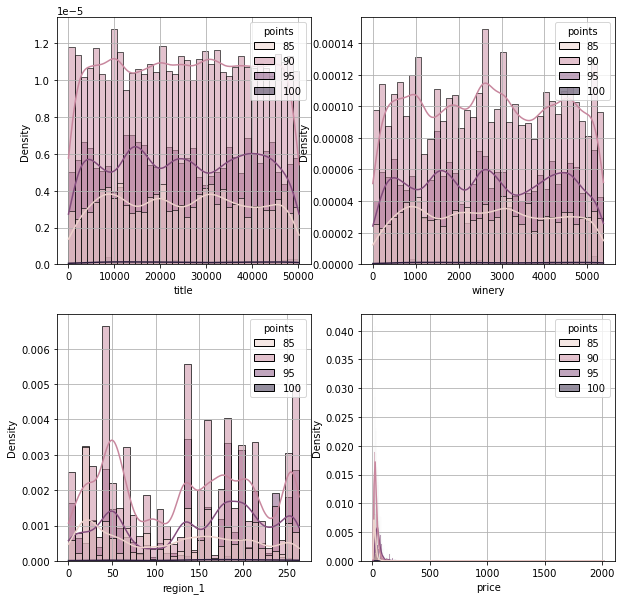

In [11]:
groups: pd.Series = y.copy()
groups[groups <= 85] = 85
groups[(groups <= 90) & (groups > 85)] = 90
groups[(groups <= 95) & (groups > 90)] = 95
groups[groups > 95] = 100

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.grid()
sns.histplot(data=x, x="title", hue=groups, kde=True, stat='density', ax=plt.gca())

plt.subplot(2, 2, 2)
plt.grid()
sns.histplot(data=x, x="winery", hue=groups, kde=True, stat='density', ax=plt.gca())

plt.subplot(2, 2, 3)
plt.grid()
sns.histplot(data=x, x="region_1", hue=groups, kde=True, stat='density', ax=plt.gca())

plt.subplot(2, 2, 4)
plt.grid()
sns.histplot(data=x, x="price", hue=groups, kde=True, stat='density', ax=plt.gca())

plt.show()
groups = None

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words='english')
description = vect.fit_transform(x['description'])
x = x.drop(columns=['description'])

In [11]:
x = x.reset_index()
x.head(3)

,index,designation,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,2,8229,14.0,19,257,17,11,5,35613,154,3819
1,3,9991,13.0,11,88,6,0,12,41792,171,4475
2,4,13437,65.0,19,257,17,11,5,43089,158,4606


In [12]:
description = description.todense()
x.drop(columns=['index'], inplace=True)

In [14]:
description = pd.DataFrame(description)
description[cols[cat]] = x
description

,0,1,2,3,4,5,6,7,8,9,...,designation,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,0,0,0,0,0,0,0,0,0,...,8229,14.0,19,257,17,11,5,35613,154,3819
1,0,0,0,0,0,0,0,0,0,0,...,9991,13.0,11,88,6,0,12,41792,171,4475
2,0,0,0,0,0,0,0,0,0,0,...,13437,65.0,19,257,17,11,5,43089,158,4606
3,0,0,0,0,0,0,0,0,0,0,...,8111,19.0,2,134,7,15,7,24080,27,2571
4,0,0,0,0,0,0,0,0,0,0,...,8229,34.0,2,1,13,15,7,27051,27,2853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54499,0,0,0,0,0,0,0,0,0,0,...,6247,20.0,2,201,1,8,4,4951,56,525
54500,0,0,0,0,0,0,0,0,0,0,...,973,35.0,2,134,7,15,7,16219,49,1749
54501,0,0,0,0,0,0,0,0,0,0,...,1559,35.0,2,134,7,15,7,20096,255,2156
54502,0,0,0,0,0,0,0,0,0,0,...,8229,22.0,2,34,7,15,7,20861,255,2244


In [18]:
x = description.copy()
description = None

In [34]:
to_one_hot = ['taster_name', 'region_2', 'taster_twitter_handle', 'province']
x.loc[:, to_one_hot] = x.loc[:, to_one_hot].astype('category')
dummies = pd.get_dummies(x.loc[:, to_one_hot])
x.drop(columns=to_one_hot, inplace=True)
x.loc[:, dummies.columns] = dummies
x.head(3)

,0,1,2,3,4,5,6,7,8,9,...,province_17,province_18,province_19,province_20,province_21,province_22,province_23,province_24,province_25,province_26
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## Task 2 Word Vectors [50pts]

Use a pretrained word-embedding (word2vec, glove or fasttext) for featurization instead of the bag-of-words model. Does this improve classification? How about combining the embedded words with the BoW model?

In [1]:
#your code here

# Task 3 Transformers (bonus / optional) [50pts] - Like Extra Assignment with 50% weight

Fine-tune a BERT model on the text data alone using the transformers library. How does this model compare to a BoW model, and how does it compare to a model using all features?

In [2]:
#your code here